# Introducción al Text Mining

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

df = pd.read_csv("spam.csv", encoding="latin-1")
df = df[["v1", "v2"]]
df.columns = ["label", "text"]

print("Ejemplos de datos")
print(df.head())

Ejemplos de datos
  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [2]:
print("Clases disponibles: " + str(df["label"].value_counts()))

Clases disponibles: label
ham     4825
spam     747
Name: count, dtype: int64


In [3]:
df["spam"] = df["label"].map({"ham": 0, "spam": 1})

df["longitud"] = df["text"].apply(len)

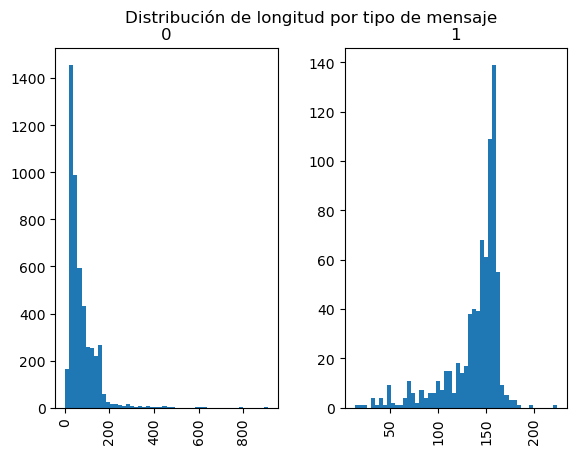

In [4]:
df["longitud"].hist(by=df["spam"], bins=50)
plt.suptitle("Distribución de longitud por tipo de mensaje")
plt.show()

In [5]:
df["tokens"] = df["text"].str.split()

df["num_palabras"] = df["tokens"].apply(len)

print("Palabras por mensaje")
print(df["num_palabras"].describe())

Palabras por mensaje
count    5572.000000
mean       15.494436
std        11.329427
min         1.000000
25%         7.000000
50%        12.000000
75%        23.000000
max       171.000000
Name: num_palabras, dtype: float64


In [6]:
todas_palabras = [palabra for tokens in df["tokens"] for palabra in tokens]
conteo = Counter(todas_palabras)
print("Palabras más frecuentes: ")
print(conteo.most_common(10))

Palabras más frecuentes: 
[('to', 2134), ('you', 1622), ('I', 1466), ('a', 1327), ('the', 1197), ('and', 857), ('in', 798), ('is', 781), ('i', 742), ('u', 692)]


In [7]:
pal_ham = Counter([palabra for tokens in df[df["spam"] == 0]["tokens"] for palabra in tokens])
pal_spam = Counter([palabra for tokens in df[df["spam"] == 1]["tokens"] for palabra in tokens])

print("Top en ham: " + str(pal_ham.most_common(5)))
print("Top en spam: " + str(pal_spam.most_common(5)))

Top en ham: [('to', 1530), ('you', 1458), ('I', 1436), ('the', 1019), ('a', 969)]
Top en spam: [('to', 604), ('a', 358), ('your', 187), ('call', 185), ('or', 185)]


In [8]:
df["tiene_free"] = df["text"].str.lower().str.contains("free").astype(int)
df["tiene_win"] = df["text"].str.lower().str.contains("win").astype(int)

print("Mensajes con 'free': " + str(df["tiene_free"].sum()))
print("Mensajes con 'win': " + str(df["tiene_win"].sum()))

Mensajes con 'free': 265
Mensajes con 'win': 166


# Primeros Pasos: Bag of Words y TF-IDF

**Bag of Words (BoW) vs TF-IDF – diferencias clave**

* **Bag of Words** crea una matriz que cuenta cuántas veces aparece cada palabra en cada documento. Es una representación simple basada en frecuencias. No tiene en cuenta si la palabra es común o específica.

* **TF-IDF (Term Frequency - Inverse Document Frequency)** también crea una matriz, pero en lugar de contar palabras, asigna un peso. Este peso aumenta si la palabra aparece muchas veces en un documento, pero disminuye si es muy común en todo el conjunto de documentos.

* **BoW** trata igual a todas las palabras frecuentes, mientras que **TF-IDF** da más importancia a las que aportan información relevante.

* Con BoW, palabras como “el”, “de”, “la” pueden tener valores altos. Con TF-IDF, esas palabras comunes suelen tener peso bajo.

* TF-IDF suele dar mejores resultados en modelos de clasificación de texto porque diferencia palabras informativas de las que no lo son.


In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

df = pd.read_csv("spam.csv", encoding="latin-1")[["v1", "v2"]]
df.columns = ["label", "text"]
df["spam"] = df["label"].map({"ham": 0, "spam": 1})

X_text = df["text"]
y = df["spam"]

In [10]:
vectorizador_bow = CountVectorizer()
X_bow = vectorizador_bow.fit_transform(X_text)

X_train, X_test, y_train, y_test = train_test_split(X_bow, y, test_size=0.3, random_state=42)

modelo_bow = LogisticRegression(max_iter=1000)
modelo_bow.fit(X_train, y_train)
y_pred_bow = modelo_bow.predict(X_test)
print("Resultados con Bag of Words")
print(classification_report(y_test, y_pred_bow))

Resultados con Bag of Words
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1453
           1       0.98      0.84      0.91       219

    accuracy                           0.98      1672
   macro avg       0.98      0.92      0.95      1672
weighted avg       0.98      0.98      0.98      1672



In [11]:
vectorizador_tfidf = TfidfVectorizer()
X_tfidf = vectorizador_tfidf.fit_transform(X_text)

X_train_tfidf, X_test_tfidf, _, _ = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)

modelo_tfidf = LogisticRegression(max_iter=1000)
modelo_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = modelo_tfidf.predict(X_test_tfidf)
print("Resultados con TF-IDF")
print(classification_report(y_test, y_pred_tfidf))

Resultados con TF-IDF
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1453
           1       1.00      0.68      0.81       219

    accuracy                           0.96      1672
   macro avg       0.98      0.84      0.89      1672
weighted avg       0.96      0.96      0.95      1672



In [12]:
print("Términos únicos en BoW: " + str(len(vectorizador_bow.get_feature_names_out())))
print("Términos únicos en TF-IDF: " + str(len(vectorizador_tfidf.get_feature_names_out())))

Términos únicos en BoW: 8672
Términos únicos en TF-IDF: 8672


# Stemming y Lemmatizing

In [13]:
import pandas as pd
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import nltk

# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('punkt_tab')
# nltk.download('stopwords')

df = pd.read_csv("spam.csv", encoding="latin-1")[["v1", "v2"]]
df.columns = ["label", "text"]
df["spam"] = df["label"].map({"ham": 0, "spam": 1})

stop_words = set(stopwords.words("english"))

df["tokens"] = df["text"].apply(lambda x: [pal for pal in word_tokenize(x.lower()) if pal.isalpha() and pal not in stop_words])


stemmer = PorterStemmer()
df["stems"] = df["tokens"].apply(lambda tokens: [stemmer.stem(pal) for pal in tokens])

lemmatizer = WordNetLemmatizer()
df["lemmas"] = df["tokens"].apply(lambda tokens: [lemmatizer.lemmatize(pal) for pal in tokens])

In [33]:
stopwords.words("english")

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [14]:
df[["tokens","stems","lemmas"]].transpose()[[2]].values

array([[list(['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply'])],
       [list(['free', 'entri', 'wkli', 'comp', 'win', 'fa', 'cup', 'final', 'tkt', 'may', 'text', 'fa', 'receiv', 'entri', 'question', 'std', 'txt', 'rate', 'c', 'appli'])],
       [list(['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply'])]],
      dtype=object)

In [15]:
stems_spam = [s for lista in df[df["spam"] == 1]["stems"] for s in lista]
lemmas_spam = [l for lista in df[df["spam"] == 1]["lemmas"] for l in lista]

print("Stems más frecuentes en spam: " + str(Counter(stems_spam).most_common(20)))
print("Lemmas más frecuentes en spam: " + str(Counter(lemmas_spam).most_common(20)))

Stems más frecuentes en spam: [('call', 365), ('free', 219), ('txt', 169), ('ur', 144), ('u', 141), ('text', 139), ('mobil', 135), ('claim', 115), ('stop', 114), ('repli', 112), ('prize', 94), ('get', 88), ('tone', 74), ('servic', 72), ('send', 70), ('new', 69), ('nokia', 68), ('award', 66), ('week', 62), ('cash', 62)]
Lemmas más frecuentes en spam: [('call', 358), ('free', 219), ('txt', 156), ('u', 149), ('ur', 144), ('text', 138), ('mobile', 135), ('claim', 115), ('stop', 114), ('reply', 105), ('prize', 94), ('c', 92), ('get', 84), ('tone', 74), ('service', 72), ('new', 69), ('send', 68), ('nokia', 65), ('week', 62), ('cash', 62)]


# Análisis posicional del texto

In [16]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk import pos_tag

# nltk.download('averaged_perceptron_tagger_eng')

df = pd.read_csv("spam.csv", encoding="latin-1")[["v1", "v2"]]
df.columns = ["label", "text"]
df["spam"] = df["label"].map({"ham": 0, "spam": 1})

df["tokens"] = df["text"].apply(lambda x: word_tokenize(x.lower()))

df["primera"] = df["tokens"].apply(lambda x: x[0] if len(x) > 0 else "")
df["ultima"] = df["tokens"].apply(lambda x: x[-1] if len(x) > 0 else "")

prim_ham = Counter(df[df["spam"] == 0]["primera"])
prim_spam = Counter(df[df["spam"] == 1]["primera"])

print("Primeras palabras más comunes en ham: " + str(prim_ham.most_common(5)))
print("Primeras palabras más comunes en spam: " + str(prim_spam.most_common(5)))

Primeras palabras más comunes en ham: [('i', 536), ('ok', 118), ('no', 109), ('sorry', 95), ('hey', 85)]
Primeras palabras más comunes en spam: [('you', 57), ('urgent', 52), ('free', 35), ('u', 20), ('private', 16)]


In [17]:
df["empieza_call"] = df["primera"].str.lower().eq("call").astype(int)
df["empieza_free"] = df["primera"].str.lower().eq("free").astype(int)

print("Mensajes que empiezan por 'call': " + str(df["empieza_call"].sum()))
print("Mensajes que empiezan por 'free': " + str(df["empieza_free"].sum()))

Mensajes que empiezan por 'call': 16
Mensajes que empiezan por 'free': 36


In [18]:
df["palabra_2"] = df["tokens"].apply(lambda x: x[1] if len(x) > 1 else "")
pal2_spam = Counter(df[df["spam"] == 1]["palabra_2"])
print("Segunda palabra más común en spam: " + str(pal2_spam.most_common(5)))

Segunda palabra más común en spam: [('!', 83), ('have', 38), ('you', 24), ('are', 20), (':', 18)]


In [19]:
df["pos_tags"] = df["tokens"].apply(lambda x: pos_tag(x) if len(x) > 0 else [])
df["pos_primera"] = df["pos_tags"].apply(lambda x: x[0][1] if len(x) > 0 else "")

pos_ham = Counter(df[df["spam"] == 0]["pos_primera"])
pos_spam = Counter(df[df["spam"] == 1]["pos_primera"])

print("Etiquetas gramaticales más comunes en ham (1ª palabra): " + str(pos_ham.most_common(5)))
print("Etiquetas gramaticales más comunes en spam (1ª palabra): " + str(pos_spam.most_common(5)))


Etiquetas gramaticales más comunes en ham (1ª palabra): [('NN', 2033), ('JJ', 499), ('RB', 451), ('DT', 239), ('NNS', 225)]
Etiquetas gramaticales más comunes en spam (1ª palabra): [('NN', 195), ('JJ', 191), ('NNS', 76), ('PRP', 69), ('VB', 51)]


In [20]:
etiquetas_pos_traducidas = {
    "NN": "nombre singular (común)",
    "NNS": "nombre plural (común)",
    "NNP": "nombre propio singular",
    "NNPS": "nombre propio plural",
    
    "VB": "verbo base",
    "VBD": "verbo en pasado",
    "VBG": "verbo en gerundio",
    "VBN": "verbo en participio pasado",
    "VBP": "verbo presente (no 3ª persona)",
    "VBZ": "verbo presente (3ª persona)",
    
    "JJ": "adjetivo",
    "JJR": "adjetivo comparativo",
    "JJS": "adjetivo superlativo",
    
    "RB": "adverbio",
    "RBR": "adverbio comparativo",
    "RBS": "adverbio superlativo",
    
    "DT": "determinante",
    "PRP": "pronombre personal",
    "PRP$": "pronombre posesivo",
    
    "IN": "preposición o subordinador",
    "CC": "conjunción coordinada",
    "CD": "número cardinal",
    "EX": "existencial 'there'",
    "FW": "palabra extranjera",
    "LS": "marcador de lista",
    "MD": "verbo modal",
    "POS": "marcador de posesivo ('s)",
    "TO": "infinitivo 'to'",
    "UH": "interjección",
    "WDT": "determinante relativo",
    "WP": "pronombre relativo",
    "WP$": "pronombre relativo posesivo",
    "WRB": "adverbio relativo"
}


In [21]:
df["pos_primera_traducida"] = df["pos_primera"].map(etiquetas_pos_traducidas)

print("Etiquetas gramaticales más comunes en ham (1ª palabra):")
print(df[df["spam"] == 0]["pos_primera_traducida"].value_counts().head(5))

print("\n\n\nEtiquetas gramaticales más comunes en spam (1ª palabra):")
print(df[df["spam"] == 1]["pos_primera_traducida"].value_counts().head(5))

Etiquetas gramaticales más comunes en ham (1ª palabra):
pos_primera_traducida
nombre singular (común)    2033
adjetivo                    499
adverbio                    451
determinante                239
nombre plural (común)       225
Name: count, dtype: int64



Etiquetas gramaticales más comunes en spam (1ª palabra):
pos_primera_traducida
nombre singular (común)    195
adjetivo                   191
nombre plural (común)       76
pronombre personal          69
verbo base                  51
Name: count, dtype: int64


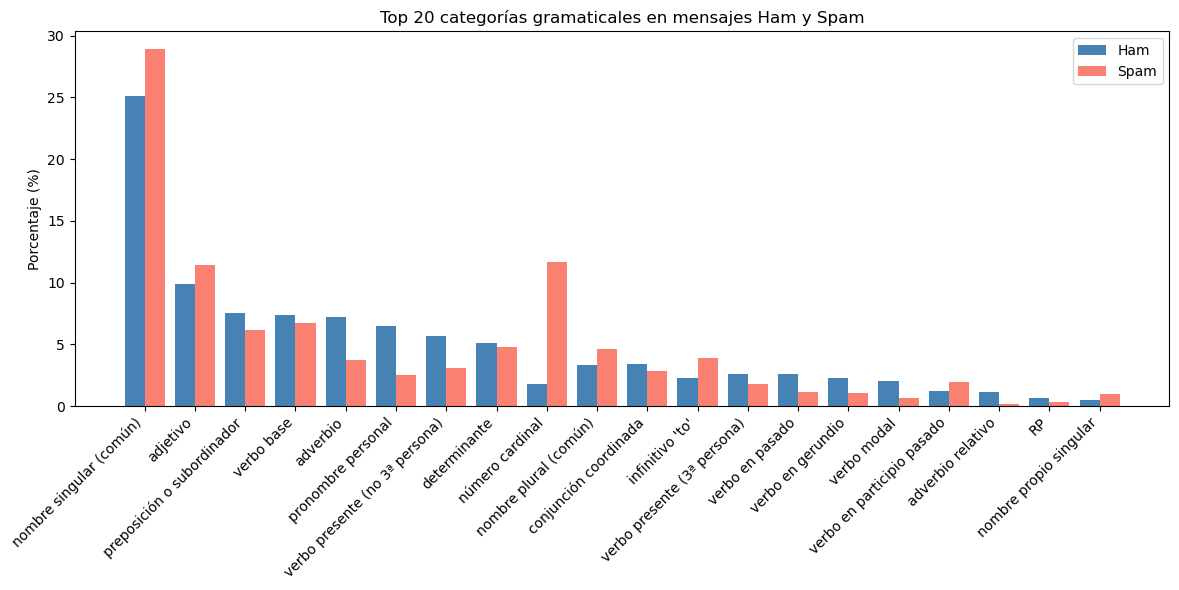

In [22]:
import matplotlib.pyplot as plt
from collections import Counter

df["todas_las_pos"] = df["pos_tags"].apply(lambda x: [etiqueta for (_, etiqueta) in x if etiqueta.isalpha()])
df["pos_traducidas"] = df["todas_las_pos"].apply(lambda etiquetas: [etiquetas_pos_traducidas.get(e, e) for e in etiquetas])

pos_ham = Counter([etiqueta for lista in df[df["spam"] == 0]["pos_traducidas"] for etiqueta in lista])
pos_spam = Counter([etiqueta for lista in df[df["spam"] == 1]["pos_traducidas"] for etiqueta in lista])

todas_etiquetas = list(set(pos_ham.keys()).union(pos_spam.keys()))
etiquetas_ordenadas = sorted(todas_etiquetas, key=lambda x: pos_ham[x] + pos_spam[x], reverse=True)[:20]

total_ham = sum(pos_ham.values())
total_spam = sum(pos_spam.values())

porc_ham = [100 * pos_ham.get(e, 0) / total_ham for e in etiquetas_ordenadas]
porc_spam = [100 * pos_spam.get(e, 0) / total_spam for e in etiquetas_ordenadas]

x = range(len(etiquetas_ordenadas))
width = 0.4

plt.figure(figsize=(12,6))
plt.bar([i - width/2 for i in x], porc_ham, width=width, label="Ham", color="steelblue")
plt.bar([i + width/2 for i in x], porc_spam, width=width, label="Spam", color="salmon")
plt.xticks(x, etiquetas_ordenadas, rotation=45, ha='right')
plt.ylabel("Porcentaje (%)")
plt.title("Top 20 categorías gramaticales en mensajes Ham y Spam")
plt.legend()
plt.tight_layout()
plt.show()



# Sentiment Analysis

In [23]:
# ! pip install textblob

In [35]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
from textblob import TextBlob
import matplotlib.pyplot as plt

# nltk.download("vader_lexicon")

df = pd.read_csv("spam.csv", encoding="latin-1")[["v1", "v2"]]
df.columns = ["label", "text"]
df["spam"] = df["label"].map({"ham": 0, "spam": 1})

analyzer = SentimentIntensityAnalyzer()
df["sentiment"] = df["text"].apply(lambda x: analyzer.polarity_scores(x)["compound"])

Sentimiento medio en mensajes ham: 0.152
Sentimiento medio en mensajes spam: 0.436


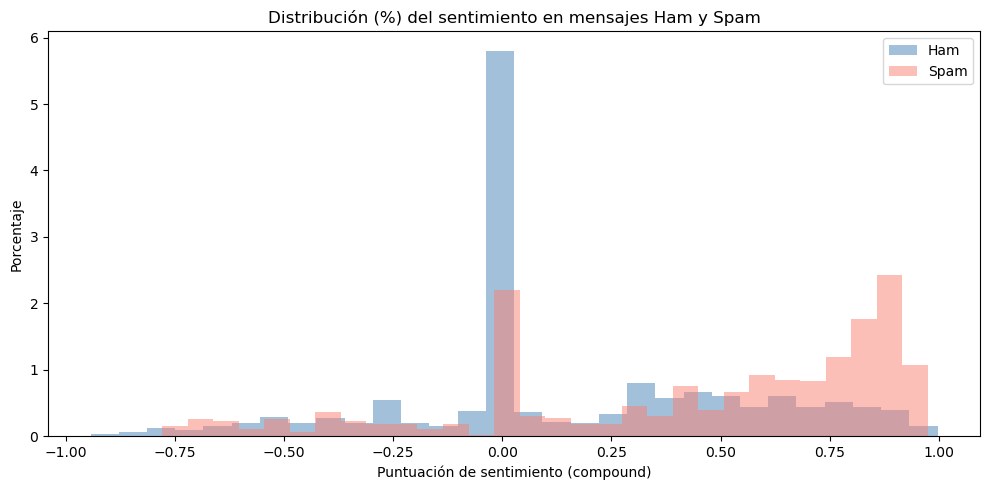

In [36]:
plt.figure(figsize=(10,5))

bins = 30

ham_sent = df[df["spam"] == 0]["sentiment"]
spam_sent = df[df["spam"] == 1]["sentiment"]

print("Sentimiento medio en mensajes ham:", round(ham_sent.mean(), 3))
print("Sentimiento medio en mensajes spam:", round(spam_sent.mean(), 3))

plt.hist(ham_sent, bins=bins, density=True, alpha=0.5, label="Ham", color="steelblue", weights=[100/len(ham_sent)]*len(ham_sent))
plt.hist(spam_sent, bins=bins, density=True, alpha=0.5, label="Spam", color="salmon", weights=[100/len(spam_sent)]*len(spam_sent))

plt.title("Distribución (%) del sentimiento en mensajes Ham y Spam")
plt.xlabel("Puntuación de sentimiento (compound)")
plt.ylabel("Porcentaje")
plt.legend()
plt.tight_layout()
plt.show()

In [37]:
df["polaridad"] = df["text"].apply(lambda x: TextBlob(x).sentiment.polarity)
df["subjetividad"] = df["text"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

print("Polaridad media - Ham:", round(df[df["spam"] == 0]["polaridad"].mean(), 3))
print("Polaridad media - Spam:", round(df[df["spam"] == 1]["polaridad"].mean(), 3))
print("Subjetividad media - Ham:", round(df[df["spam"] == 0]["subjetividad"].mean(), 3))
print("Subjetividad media - Spam:", round(df[df["spam"] == 1]["subjetividad"].mean(), 3))

Polaridad media - Ham: 0.116
Polaridad media - Spam: 0.189
Subjetividad media - Ham: 0.353
Subjetividad media - Spam: 0.446


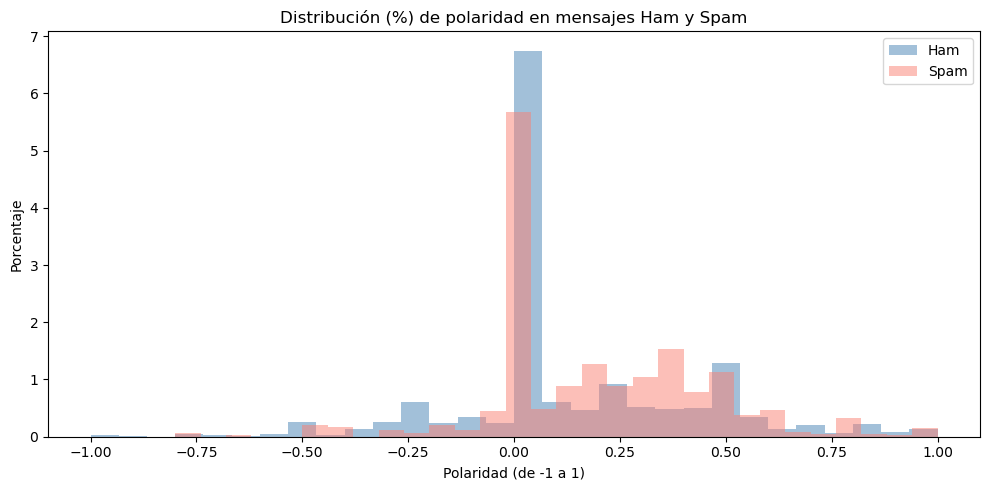

In [40]:
plt.figure(figsize=(10,5))
plt.hist(df[df["spam"] == 0]["polaridad"], bins=30, density=True, alpha=0.5, label="Ham", color="steelblue", weights=[100/len(df[df["spam"] == 0])]*len(df[df["spam"] == 0]))
plt.hist(df[df["spam"] == 1]["polaridad"], bins=30, density=True, alpha=0.5, label="Spam", color="salmon", weights=[100/len(df[df["spam"] == 1])]*len(df[df["spam"] == 1]))
plt.title("Distribución (%) de polaridad en mensajes Ham y Spam")
plt.xlabel("Polaridad (de -1 a 1)")
plt.ylabel("Porcentaje")
plt.legend()
plt.tight_layout()
plt.show()

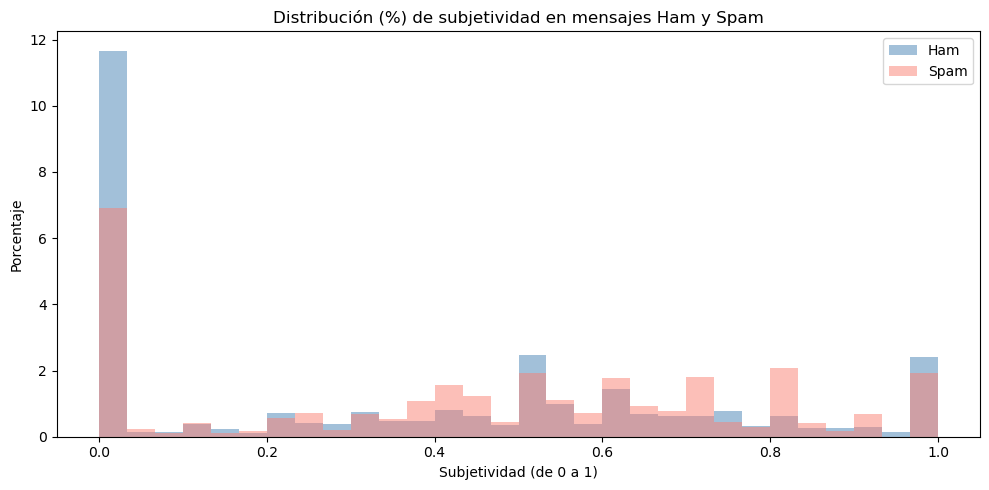

In [41]:
plt.figure(figsize=(10,5))
plt.hist(df[df["spam"] == 0]["subjetividad"], bins=30, density=True, alpha=0.5, label="Ham", color="steelblue", weights=[100/len(df[df["spam"] == 0])]*len(df[df["spam"] == 0]))
plt.hist(df[df["spam"] == 1]["subjetividad"], bins=30, density=True, alpha=0.5, label="Spam", color="salmon", weights=[100/len(df[df["spam"] == 1])]*len(df[df["spam"] == 1]))
plt.title("Distribución (%) de subjetividad en mensajes Ham y Spam")
plt.xlabel("Subjetividad (de 0 a 1)")
plt.ylabel("Porcentaje")
plt.legend()
plt.tight_layout()
plt.show()

# Machine Learning y Text Mining. Clasificación automática

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from nltk import word_tokenize, pos_tag
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import numpy as np
import nltk

df = pd.read_csv("spam.csv", encoding="latin-1")[["v1", "v2"]]
df.columns = ["label", "text"]
df["spam"] = df["label"].map({"ham": 0, "spam": 1})

analyzer = SentimentIntensityAnalyzer()

def extra_features(df):
    df_ = df.copy()
    df_["pos_tag_str"] = df_["text"].apply(lambda x: " ".join([tag for (_, tag) in pos_tag(word_tokenize(x))]))
    df_["polaridad"] = df_["text"].apply(lambda x: TextBlob(x).sentiment.polarity)
    df_["compound"] = df_["text"].apply(lambda x: analyzer.polarity_scores(x)["compound"])
    return df_[["text", "pos_tag_str", "polaridad", "compound"]]

X_extra = extra_features(df)
y = df["spam"]

columnas_texto = ["text", "pos_tag_str"]
columnas_numericas = ["polaridad", "compound"]

preprocesado = ColumnTransformer([
    ("tfidf_texto", TfidfVectorizer(), "text"),
    ("tfidf_pos", TfidfVectorizer(), "pos_tag_str"),
    ("num", StandardScaler(), columnas_numericas)
])

pipeline = Pipeline([
    ("preproc", preprocesado),
    ("xgb", XGBClassifier( eval_metric="logloss"))
])

param_grid = {
    "preproc__tfidf_texto__max_df": [0.8, 1.0],
    "preproc__tfidf_texto__ngram_range": [(1,1), (1,2)],
    "preproc__tfidf_pos__max_df": [0.8],
    "preproc__tfidf_pos__ngram_range": [(1,2)],
    "xgb__n_estimators": [300],
    "xgb__max_depth": [3, 6],
    "xgb__learning_rate": [0.1, 0.3]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring="f1", n_jobs=-1, verbose=1)
grid.fit(X_extra, y)

print("Mejores parámetros: " + str(grid.best_params_))
print("Mejor score CV: " + str(round(grid.best_score_, 3)))

X_train, X_test, y_train, y_test = train_test_split(X_extra, y, test_size=0.3, random_state=42)
mejor_modelo = grid.best_estimator_
mejor_modelo.fit(X_train, y_train)
y_pred = mejor_modelo.predict(X_test)

print("Evaluación final con mejores parámetros")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Mejores parámetros: {'preproc__tfidf_pos__max_df': 0.8, 'preproc__tfidf_pos__ngram_range': (1, 2), 'preproc__tfidf_texto__max_df': 0.8, 'preproc__tfidf_texto__ngram_range': (1, 1), 'xgb__learning_rate': 0.3, 'xgb__max_depth': 3, 'xgb__n_estimators': 300}
Mejor score CV: 0.933
Evaluación final con mejores parámetros
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1453
           1       0.98      0.89      0.93       219

    accuracy                           0.98      1672
   macro avg       0.98      0.95      0.96      1672
weighted avg       0.98      0.98      0.98      1672



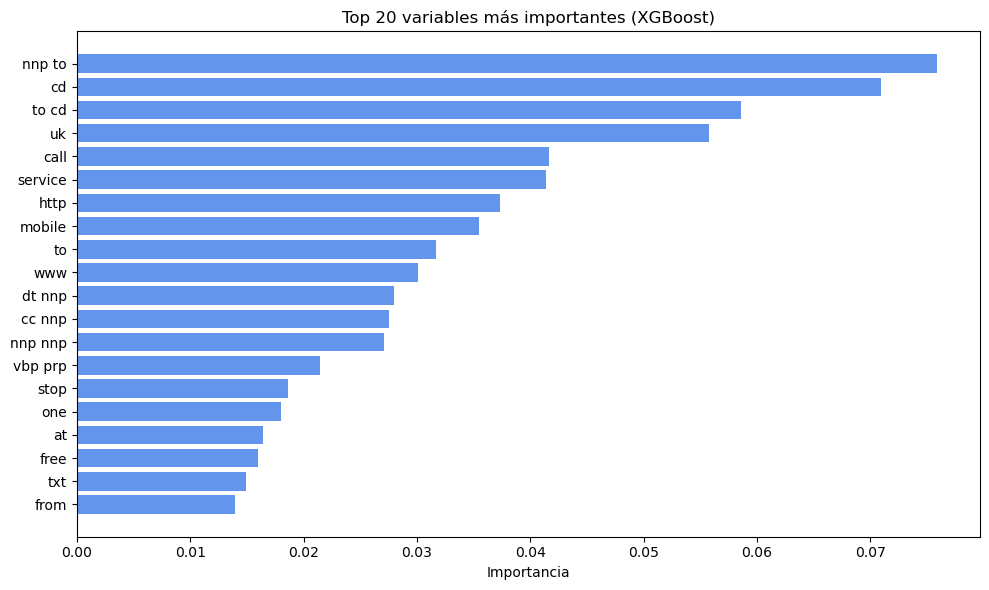

In [30]:
modelo_xgb = mejor_modelo.named_steps["xgb"]

preproc = mejor_modelo.named_steps["preproc"]
tfidf_texto = preproc.named_transformers_["tfidf_texto"]
tfidf_pos = preproc.named_transformers_["tfidf_pos"]
scaler = preproc.named_transformers_["num"]

nombres_tfidf_texto = tfidf_texto.get_feature_names_out()
nombres_tfidf_pos = tfidf_pos.get_feature_names_out()
nombres_numericas = columnas_numericas

nombres_totales = np.concatenate([nombres_tfidf_texto, nombres_tfidf_pos, nombres_numericas])

importancias = modelo_xgb.feature_importances_
top_idx = np.argsort(importancias)[-20:][::-1]


plt.figure(figsize=(10,6))
plt.barh(range(len(top_idx)), importancias[top_idx], align='center', color='cornflowerblue')
plt.yticks(range(len(top_idx)), [nombres_totales[i] for i in top_idx])
plt.xlabel("Importancia")
plt.title("Top 20 variables más importantes (XGBoost)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Topic Modeling en Python

Tópico 0: get, message, co, com, uk, free, stop, www, ur, text
Tópico 1: 100, send, cash, reply, www, free, win, ur, stop, txt
Tópico 2: ringtone, video, camera, new, reply, phone, text, mobile, call, free
Tópico 3: account, chat, nokia, tones, 150p, ur, uk, free, txt, call
Tópico 4: award, mobile, contact, guaranteed, cash, urgent, min, claim, prize, call


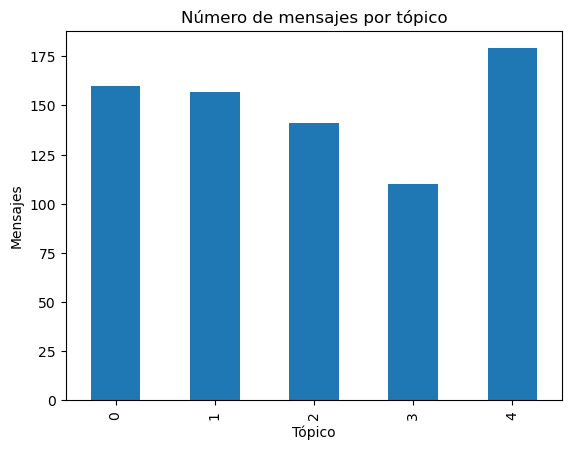

In [42]:
import pandas as pd
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

# nltk.download('stopwords')

df = pd.read_csv("spam.csv", encoding="latin-1")[["v1", "v2"]]
df.columns = ["label", "text"]

df_spam = df[df["label"] == "spam"].copy()

stop_words = stopwords.words('english')

vectorizador = CountVectorizer(stop_words=stop_words, max_df=0.9, min_df=5)
X_bow = vectorizador.fit_transform(df_spam["text"])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_bow)

palabras = vectorizador.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    top_indices = topic.argsort()[-10:]
    top_words = [palabras[i] for i in top_indices]
    print("Tópico " + str(idx) + ": " + ", ".join(top_words))

tema_distribucion = lda.transform(X_bow)
df_spam["tema"] = tema_distribucion.argmax(axis=1)

df_spam["tema"].value_counts().sort_index().plot(kind="bar")
plt.title("Número de mensajes por tópico")
plt.xlabel("Tópico")
plt.ylabel("Mensajes")
plt.show()


In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Cargar datos
df = pd.read_csv("spam.csv", encoding="latin-1")[["v1", "v2"]]
df.columns = ["label", "text"]

# Separar spam y ham
df_spam = df[df["label"] == "spam"].copy()
df_ham = df[df["label"] == "ham"].copy()

stop_words = stopwords.words('english')

# --- SPAM ---
vector_spam = CountVectorizer(stop_words=stop_words, max_df=0.9, min_df=5)
X_spam = vector_spam.fit_transform(df_spam["text"])

lda_spam = LatentDirichletAllocation(n_components=5, random_state=42)
lda_spam.fit(X_spam)

palabras_spam = vector_spam.get_feature_names_out()
for idx, topic in enumerate(lda_spam.components_):
    top_indices = topic.argsort()[-10:]
    top_words = [palabras_spam[i] for i in top_indices]
    print("Tópico spam " + str(idx) + ": " + ", ".join(top_words))

tema_spam = lda_spam.transform(X_spam)
df_spam["tema"] = tema_spam.argmax(axis=1)

print("\n\n")
# --- HAM ---
vector_ham = CountVectorizer(stop_words=stop_words, max_df=0.9, min_df=5)
X_ham = vector_ham.fit_transform(df_ham["text"])

lda_ham = LatentDirichletAllocation(n_components=5, random_state=42)
lda_ham.fit(X_ham)

palabras_ham = vector_ham.get_feature_names_out()
for idx, topic in enumerate(lda_ham.components_):
    top_indices = topic.argsort()[-10:]
    top_words = [palabras_ham[i] for i in top_indices]
    print("Tópico ham " + str(idx) + ": " + ", ".join(top_words))

tema_ham = lda_ham.transform(X_ham)
df_ham["tema"] = tema_ham.argmax(axis=1)

# --- Gráfico comparativo ---

conteo_spam = df_spam["tema"].value_counts().sort_index()
conteo_ham = df_ham["tema"].value_counts().sort_index()

temas = sorted(set(conteo_spam.index).union(conteo_ham.index))
valores_spam = [conteo_spam.get(t, 0) for t in temas]
valores_ham = [conteo_ham.get(t, 0) for t in temas]

x = range(len(temas))
width = 0.4

Tópico spam 0: get, message, co, com, uk, free, stop, www, ur, text
Tópico spam 1: 100, send, cash, reply, www, free, win, ur, stop, txt
Tópico spam 2: ringtone, video, camera, new, reply, phone, text, mobile, call, free
Tópico spam 3: account, chat, nokia, tones, 150p, ur, uk, free, txt, call
Tópico spam 4: award, mobile, contact, guaranteed, cash, urgent, min, claim, prize, call



Tópico ham 0: one, come, ur, care, get, like, yeah, take, lt, gt
Tópico ham 1: think, much, night, like, dont, get, know, later, sorry, call
Tópico ham 2: get, amp, also, today, dear, pls, hi, happy, know, ur
Tópico ham 3: phone, im, back, babe, day, hope, home, love, ok, good
Tópico ham 4: already, ok, wat, going, ì_, come, da, got, lor, go
